In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from random import randint

from sklearn.model_selection import cross_val_score, train_test_split

from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import * 
from keras import regularizers
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
img_rows, img_cols, img_channels = 224,224,3

In [0]:
train_images = []
train_labels = []

val_images = []
val_labels = []

test_images = []
test_labels = []

Read Images and Labels

In [0]:
for dirname, _, filenames in os.walk('/content/drive/My Drive/Kaggle'):
  for filename in filenames:
    image = cv2.imread(os.path.join(dirname, filename))
    image = cv2.resize(image, (img_rows, img_cols))
    splitted_dir = dirname.split('/')
    image_dir = splitted_dir[-2]
    label = splitted_dir[-1]
    if image_dir == 'train':
        train_images.append(image)
        if label == 'NORMAL':
            train_labels.append(0)
        else:
            train_labels.append(1)
    elif image_dir == 'val':
        val_images.append(image)
        if label == 'NORMAL':
            val_labels.append(0)
        else:
            val_labels.append(1)
    else:
        test_images.append(image)
        if label == 'NORMAL':
            test_labels.append(1)
        else:
            test_labels.append(0)

In [0]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
test_images = np.array(test_images)

In [0]:
train_labels = to_categorical(train_labels, num_classes = 2)
val_labels = to_categorical(val_labels, num_classes = 2)
test_labels = to_categorical(test_labels, num_classes = 2)

Data Normalization

In [0]:
train_images = train_images / 255.0

Data Visualization

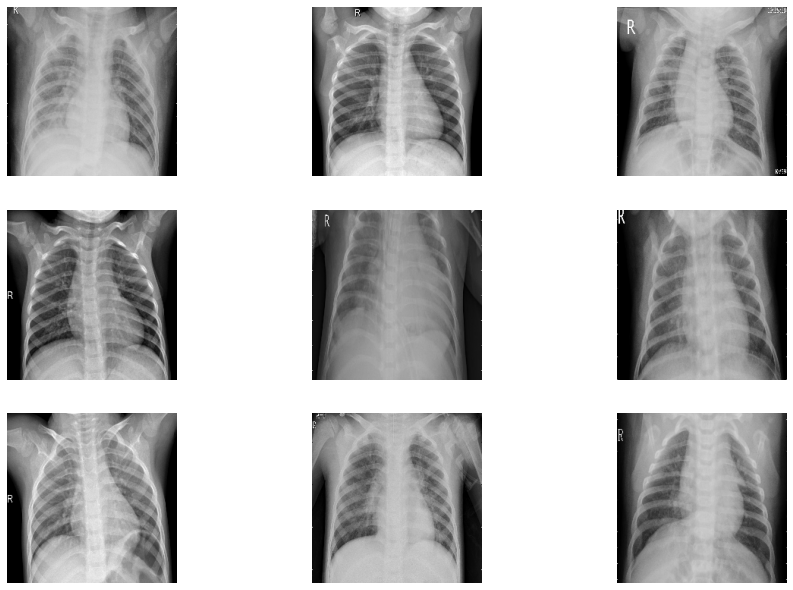

In [9]:
f,ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,2,2)
for i in range(0,3,1):
    for j in range(0,3,1):
        rnd_number = randint(0,len(train_images))
        ax[i,j].imshow(train_images[rnd_number])
        ax[i,j].axis('off')

Building CNN Architecture

In [0]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size=(5,5), padding = 'Same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 64, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 16, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 32, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=(1,1)))

model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size=(5,5), padding = 'Same' ,activation='relu', input_shape=(224,224,3)))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters = 32, kernel_size=(5,5), padding = 'Same', activation='relu', input_shape=(224,224,3)))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(256, activation = "relu",kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))

model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))

Summary of Architecture

In [32]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_123 (Conv2D)          (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 108, 108, 64)      102464    
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 50, 50, 64)        102464    
_________________________________________________________________
batch_normalization_51 (Batc (None, 50, 50, 64)      

Adam Optimizer with lr = 0.001

In [33]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Save the model if validation accuracy improved 

In [0]:
filepath="/content/drive/My Drive/Kaggle/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,earlystopping]

Fit the model

In [0]:
model.fit(train_images,train_labels, batch_size=128, epochs = 5)

Epoch 1/5
5216/5216 [==============================] - 907s 174ms/step - loss: 0.4341 - acc: 0.8014
Epoch 2/5
5216/5216 [==============================] - 907s 174ms/step - loss: 0.2433 - acc: 0.9007
Epoch 3/5
5216/5216 [==============================] - 907s 174ms/step - loss: 0.2131 - acc: 0.9145
Epoch 4/5
5216/5216 [==============================] - 909s 174ms/step - loss: 0.1727 - acc: 0.9333
Epoch 5/5
5216/5216 [==============================] - 909s 174ms/step - loss: 0.1472 - acc: 0.9419


In [0]:
model.save("IdentifyingMedicalDiagnosesCNN.h5") 

In [0]:
score = model.evaluate(val_images, val_labels, verbose=0)